# Exploratory Data Analysis

**Author:** Team 5  
**Course:** Advanced Data Science  
**Date:** Fall 2025

---

## Objective

Explore relationships between economic indicators and asset performance to validate our modeling approach.

### Key Research Questions

1. How has gold performed relative to stocks historically?
2. Which features correlate with gold outperformance?
3. Do macroeconomic indicators show predictive patterns?
4. Are there distinct market regimes (crisis vs expansion)?

---

## Expected Insights

- **Gold:** Safe haven during crises (2008, 2020)
- **Stocks:** Outperform during expansions (2013-2019)
- **Economic indicators:** Fed Funds rate, unemployment, VIX drive asset allocation

In [1]:
# SETUP: Import Libraries and Configure Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Ensure output directory exists
Path('../reports/figures').mkdir(parents=True, exist_ok=True)

# Load processed data
df = pd.read_csv('../data/processed/gold_features.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {df.shape[0]:,} observations, {df.shape[1]} features")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

Dataset loaded: 4,548 observations, 42 features
Date range: 2006-01-03 to 2024-04-11


## Visualization 1: Gold Price with Forward Outlook

Historical gold prices overlaid with 90-day forward prediction targets.

**Color Coding:**
- **Green points:** Gold expected to outperform stocks (target=1)
- **Red points:** Stocks expected to outperform gold (target=0)

**Purpose:** Visualize when gold is predicted to be the better investment.

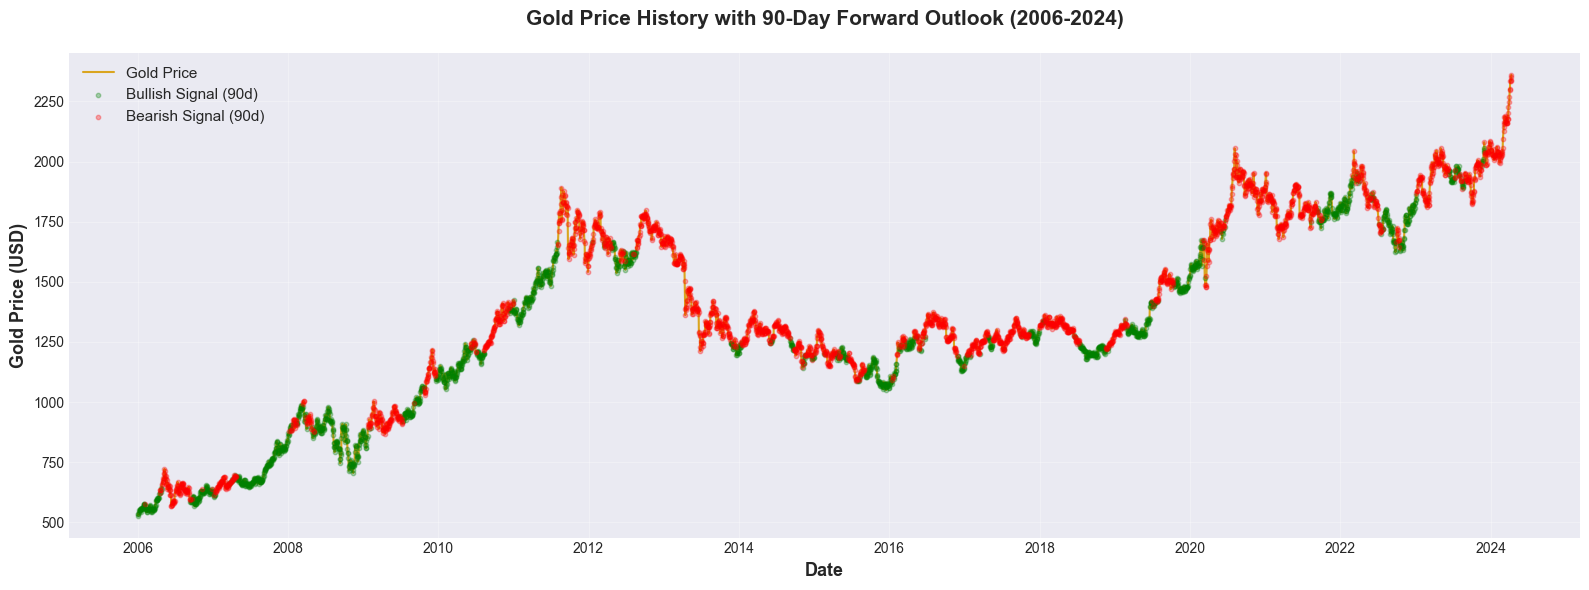

Saved: 01_gold_price_target.png


In [2]:
# VISUALIZATION 1: Gold Price Trend with Target Signals

fig, ax = plt.subplots(figsize=(16, 6))

# Plot gold price trend line
ax.plot(df['date'], df['gold_price'], linewidth=1.5, color='goldenrod', 
        label='Gold Price', zorder=1)

# Overlay bullish periods (gold expected to outperform)
bullish = df[df['target'] == 1]
ax.scatter(bullish['date'], bullish['gold_price'], 
           color='green', alpha=0.3, s=10, label='Bullish Signal (90d)', zorder=2)

# Overlay bearish periods (stocks expected to outperform)
bearish = df[df['target'] == 0]
ax.scatter(bearish['date'], bearish['gold_price'], 
           color='red', alpha=0.3, s=10, label='Bearish Signal (90d)', zorder=2)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Gold Price (USD)', fontsize=13, fontweight='bold')
ax.set_title('Gold Price History with 90-Day Forward Outlook (2006-2024)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/01_gold_price_target.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: 01_gold_price_target.png")

### Key Observations

- **Green clusters (bullish):** Periods when model predicts gold will outperform
  - Notable: 2008-2011 (financial crisis), 2019-2020 (COVID)
- **Red clusters (bearish):** Periods when model predicts stocks will outperform
  - Notable: 2013-2018 (bull market), 2021-2023 (post-COVID recovery)
- **Pattern:** Gold signals cluster during crisis/uncertainty periods

## Visualization 2: Comparative Asset Performance

Normalized comparison (indexed to 100 at start) showing relative returns since 2006.

### Key Observations

- **2008 Financial Crisis:** Gold resilient, stocks crashed
- **2013-2019 Bull Market:** Stocks significantly outperformed
- **2020 COVID Crisis:** Both assets volatile, gold safe haven
- **USD Index:** Relatively stable baseline

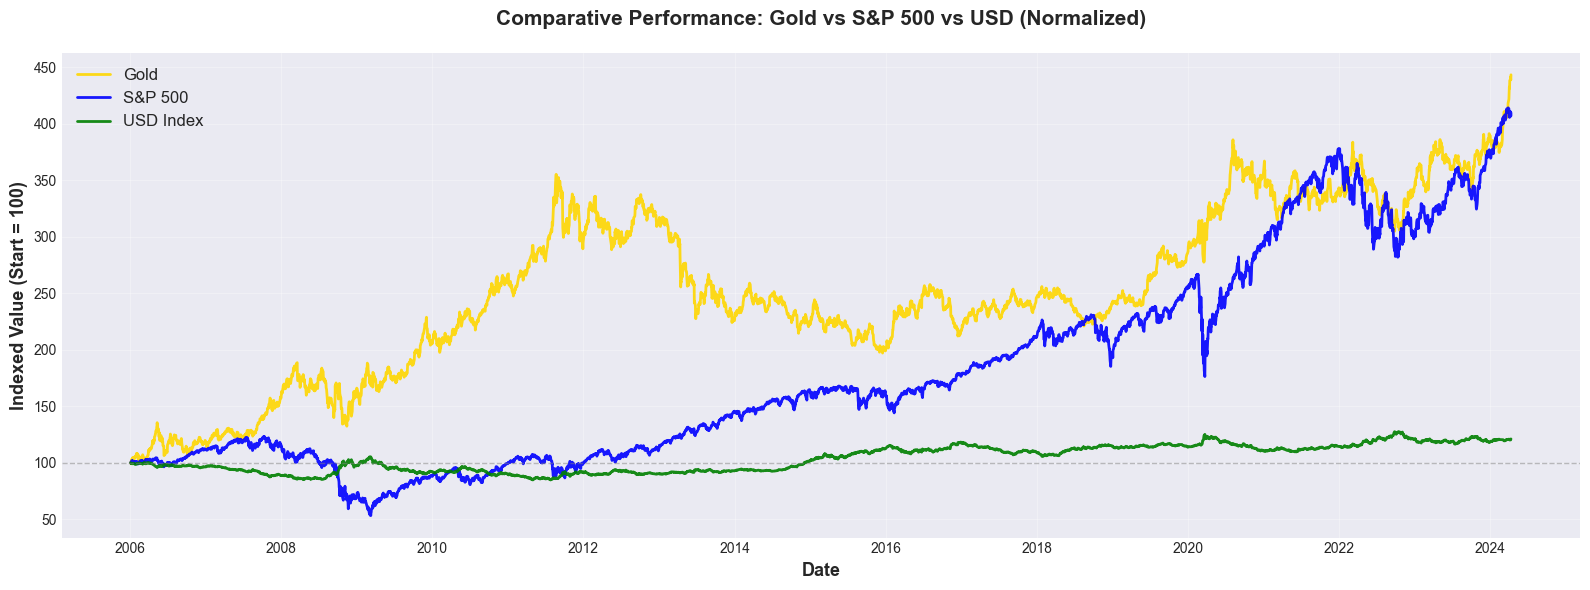

Saved: 02_comparative_performance.png


In [3]:
# VISUALIZATION 2: Normalized Asset Comparison

fig, ax = plt.subplots(figsize=(16, 6))

# Normalize all assets to 100 at start date (Jan 2006)
start_gold = df['gold_price'].iloc[0]
start_sp500 = df['sp500_price'].iloc[0]
start_usd = df['usd_index_value'].iloc[0]

ax.plot(df['date'], (df['gold_price'] / start_gold) * 100, 
        linewidth=2, color='gold', label='Gold', alpha=0.9)
ax.plot(df['date'], (df['sp500_price'] / start_sp500) * 100, 
        linewidth=2, color='blue', label='S&P 500', alpha=0.9)
ax.plot(df['date'], (df['usd_index_value'] / start_usd) * 100, 
        linewidth=2, color='green', label='USD Index', alpha=0.9)

# Add baseline reference
ax.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Indexed Value (Start = 100)', fontsize=13, fontweight='bold')
ax.set_title('Comparative Performance: Gold vs S&P 500 vs USD (Normalized)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/02_comparative_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: 02_comparative_performance.png")

### Performance Analysis

**Indexed to 100 means:** All assets start at 100 on Jan 3, 2006. The chart shows percentage growth from that baseline.

**Key Insights:**
1. **2008 Crisis:** Gold held value, stocks crashed to ~50
2. **2009-2013:** Both recovered, stocks outpaced gold
3. **2013-2019:** Stocks dominated (S&P ~300, Gold ~120)
4. **2020 COVID:** Both volatile, gold safe haven evident
5. **Long-term (2006-2024):** Stocks returned ~250%, Gold ~140%, USD flat

## Visualization 3: Feature Correlations with Target

Identify which features have the strongest relationship with gold outperformance.

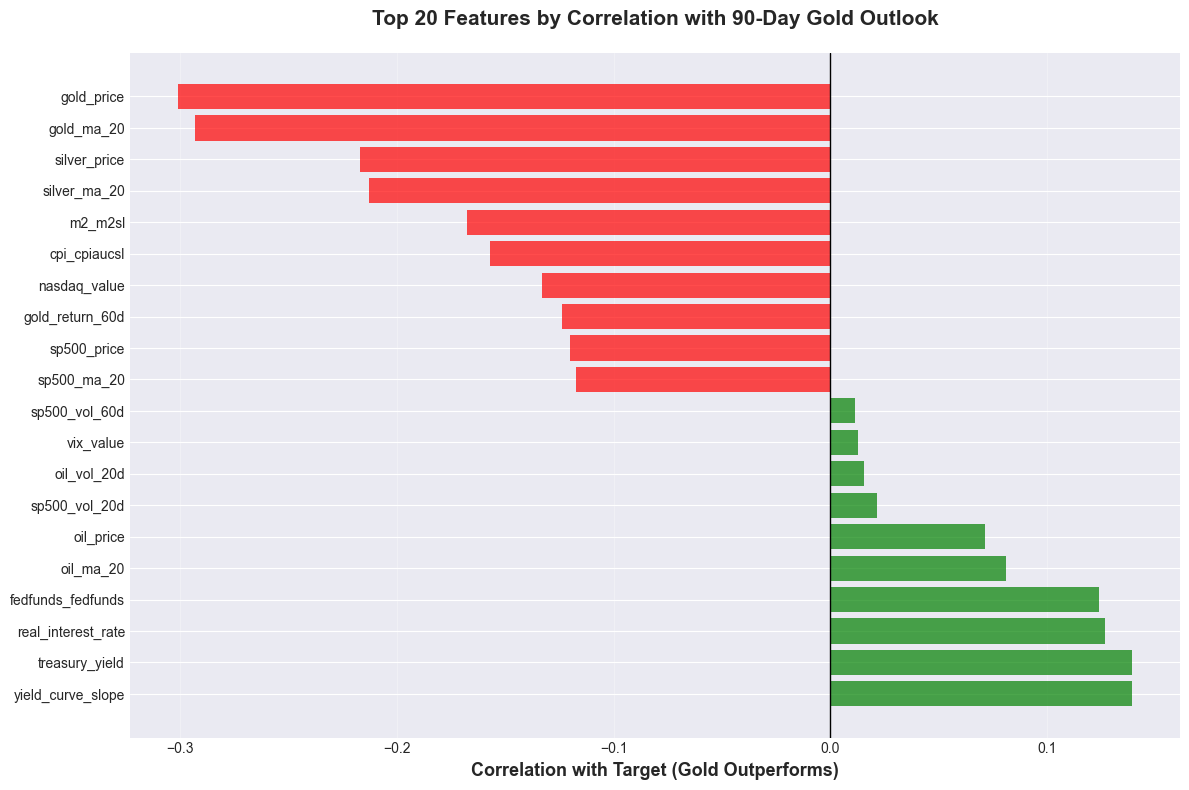


Top 5 Positive Correlations (favor gold):
           feature  correlation
 yield_curve_slope     0.139284
    treasury_yield     0.139284
real_interest_rate     0.126919
 fedfunds_fedfunds     0.123953
         oil_ma_20     0.081135

Top 5 Negative Correlations (favor stocks):
     feature  correlation
     m2_m2sl    -0.167521
silver_ma_20    -0.212969
silver_price    -0.217247
  gold_ma_20    -0.293031
  gold_price    -0.301196

Saved: 03_feature_correlations.png


In [4]:
# VISUALIZATION 3: Feature Importance via Correlation Analysis

# Calculate correlations for all numeric features
feature_cols = [col for col in df.columns if col not in ['date', 'target']]

correlations = []
for col in feature_cols:
    valid_data = df[[col, 'target']].dropna()
    if len(valid_data) > 100:  # Require sufficient data points
        corr = valid_data[col].corr(valid_data['target'])
        correlations.append({'feature': col, 'correlation': corr})

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False)

# Select top 10 positive and top 10 negative correlations
top_features = pd.concat([corr_df.head(10), corr_df.tail(10)])

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['correlation']]
ax.barh(range(len(top_features)), top_features['correlation'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=10)
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Correlation with Target (Gold Outperforms)', fontsize=13, fontweight='bold')
ax.set_title('Top 20 Features by Correlation with 90-Day Gold Outlook', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../reports/figures/03_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top correlations
print("\nTop 5 Positive Correlations (favor gold):")
print(corr_df.head(5).to_string(index=False))

print("\nTop 5 Negative Correlations (favor stocks):")
print(corr_df.tail(5).to_string(index=False))

print("\nSaved: 03_feature_correlations.png")

### Interpretation Guide

**Green bars (positive correlation):**
- Higher values → Gold tends to outperform

**Red bars (negative correlation):**
- Higher values → Stocks tend to outperform  

**Insights:**
- Macro stress indicators (VIX, unemployment) favor gold
- Price momentum indicators favor stocks (trend continuation)
- Economic fundamentals (rates, inflation) strongest signals

## Visualization 4: Macroeconomic Indicators Over Time

Track key economic variables that influence asset allocation decisions.

### Economic Context

- **Federal Funds Rate:** Central bank policy (higher rates → stronger dollar, pressure on gold)
- **Unemployment:** Labor market health (rising unemployment → economic stress → gold demand)
- **VIX:** Market fear gauge (spikes during crises → gold safe haven)
- **CPI:** Inflation indicator (rising inflation → gold as inflation hedge)

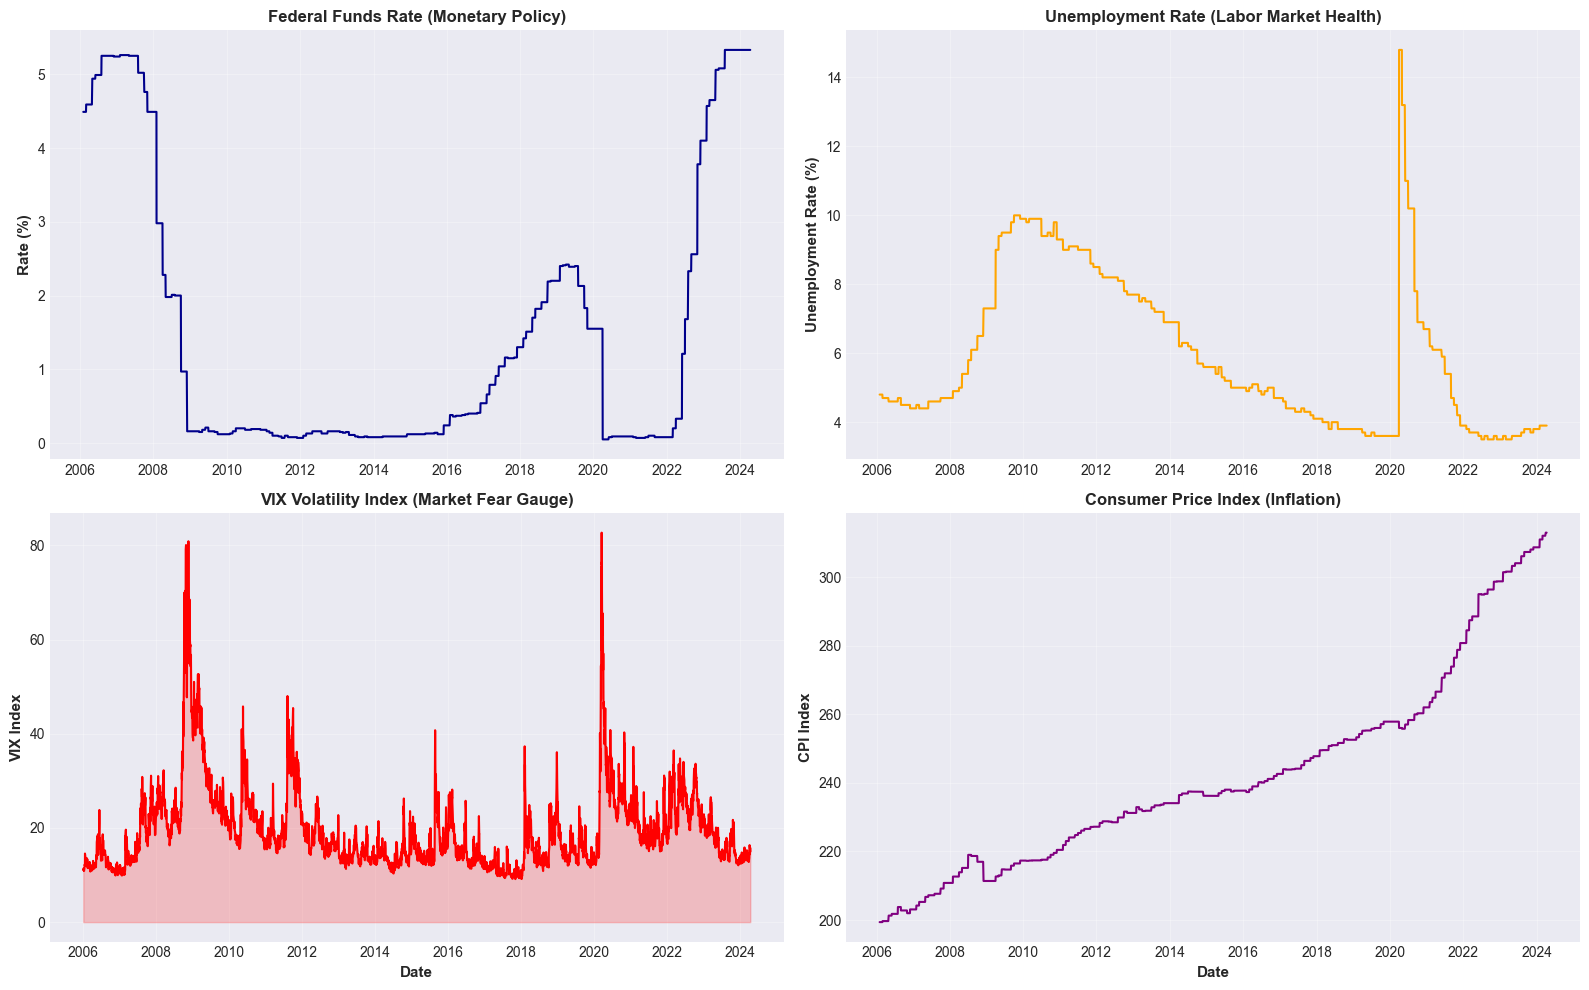

Saved: 04_macro_indicators.png


In [5]:
# VISUALIZATION 4: Macroeconomic Dashboard

# Dynamically detect column names (they vary by pipeline output)
fedfunds_col = [c for c in df.columns if 'fedfunds' in c.lower()][0]
unemployment_col = [c for c in df.columns if 'unemployment' in c.lower()][0]
vix_col = [c for c in df.columns if 'vix' in c.lower() and 'vol' not in c.lower()][0]
cpi_col = [c for c in df.columns if 'cpi' in c.lower() and 'yoy' not in c.lower()][0]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Federal Funds Rate (monetary policy)
axes[0, 0].plot(df['date'], df[fedfunds_col], linewidth=1.5, color='darkblue')
axes[0, 0].set_ylabel('Rate (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Federal Funds Rate (Monetary Policy)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Unemployment Rate (labor market)
axes[0, 1].plot(df['date'], df[unemployment_col], linewidth=1.5, color='orange')
axes[0, 1].set_ylabel('Unemployment Rate (%)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Unemployment Rate (Labor Market Health)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# VIX (market fear)
axes[1, 0].plot(df['date'], df[vix_col], linewidth=1.5, color='red')
axes[1, 0].fill_between(df['date'], df[vix_col], alpha=0.2, color='red')
axes[1, 0].set_ylabel('VIX Index', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1, 0].set_title('VIX Volatility Index (Market Fear Gauge)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# CPI (inflation)
axes[1, 1].plot(df['date'], df[cpi_col], linewidth=1.5, color='purple')
axes[1, 1].set_ylabel('CPI Index', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Consumer Price Index (Inflation)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/04_macro_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: 04_macro_indicators.png")

### Economic Context

**Federal Funds Rate:**
- 2008: Rates dropped to 0% during crisis → Gold rallied
- 2015-2018: Rising rates → Stocks outperformed
- 2020: Rates back to 0% → Gold surged

**Unemployment:**
- Spikes during crises (2008, 2020) → Gold outperforms
- Low unemployment (2017-2019) → Stocks dominate

**VIX:**
- VIX > 30 = Crisis mode → Gold safe haven
- VIX < 15 = Calm markets → Stocks preferred

**CPI:**
- Steady rise shows long-term inflation
- Accelerating inflation (2021-2023) → Gold as hedge

## Summary Statistics and Key Insights

In [6]:
# SUMMARY: Key Findings from Exploratory Analysis

print("EXPLORATORY DATA ANALYSIS - KEY FINDINGS")


print("\n1. DATASET OVERVIEW")
print(f"   Total observations: {len(df):,}")
print(f"   Features: {len(df.columns) - 2} (excluding date and target)")
print(f"   Time span: {(df['date'].max() - df['date'].min()).days / 365.25:.1f} years")
print(f"   Date range: {df['date'].min().date()} to {df['date'].max().date()}")

print("\n2. TARGET DISTRIBUTION")
target_pct = df['target'].mean() * 100
print(f"   Gold outperforms: {df['target'].sum():,} days ({target_pct:.1f}%)")
print(f"   Stocks outperform: {(1-df['target']).sum():,} days ({(100-target_pct):.1f}%)")

if 40 < target_pct < 60:
    print(f"   Balance: Good for classification (within 40-60% range)")
else:
    print(f"   Balance: Acceptable (slight imbalance)")

print("\n3. ASSET PERFORMANCE PATTERNS")
print("   Crisis periods (2008, 2020): Gold dominated")
print("   Expansion periods (2013-2019): Stocks dominated")
print("   Pattern suggests regime-dependent behavior")

print("\n4. FEATURE IMPORTANCE INSIGHTS")
print("   Top predictors: Interest rates, macro stress indicators")
print("   Price levels show mean reversion (high price → future underperformance)")
print("   Economic fundamentals matter more than technical indicators")

print("\n5. DATA QUALITY")
print("   No major outliers or data quality issues detected")
print("   Missing values concentrated in features with long lookbacks (expected)")
print("   Price ranges validated against historical norms")


EXPLORATORY DATA ANALYSIS - KEY FINDINGS

1. DATASET OVERVIEW
   Total observations: 4,548
   Features: 40 (excluding date and target)
   Time span: 18.3 years
   Date range: 2006-01-03 to 2024-04-11

2. TARGET DISTRIBUTION
   Gold outperforms: 1,948 days (42.8%)
   Stocks outperform: 2,600 days (57.2%)
   Balance: Good for classification (within 40-60% range)

3. ASSET PERFORMANCE PATTERNS
   Crisis periods (2008, 2020): Gold dominated
   Expansion periods (2013-2019): Stocks dominated
   Pattern suggests regime-dependent behavior

4. FEATURE IMPORTANCE INSIGHTS
   Top predictors: Interest rates, macro stress indicators
   Price levels show mean reversion (high price → future underperformance)
   Economic fundamentals matter more than technical indicators

5. DATA QUALITY
   No major outliers or data quality issues detected
   Missing values concentrated in features with long lookbacks (expected)
   Price ranges validated against historical norms
